<a href="https://colab.research.google.com/github/zhihaohaoran/nerf/blob/main/localgp_sfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd /content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis

/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis


In [1]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 20.2 MB/s eta 0:00:00


#This section is to find the top 4 images contribute to point cloud.

In [2]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 16.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.distributions import MultitaskMultivariateNormal
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def load_points3D(file_path):
    points3d_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#') or len(line.strip()) == 0:
                continue
            parts = line.split()
            point_id = int(parts[0])
            x, y, z = map(float, parts[1:4])
            r, g, b = map(int, parts[4:7])
            points3d_dict[point_id] = [x, y, z, r / 255.0, g / 255.0, b / 255.0]
    return points3d_dict

file_path_points3d = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/sfm/points3D.txt'
points3d_dict = load_points3D(file_path_points3d)


#
def parse_images_file(file_path, points3d_dict):
    valid_data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if lines[i].startswith('#') or not lines[i].strip():
                i += 1
                continue

            image_data = lines[i].strip().split()
            image_name = image_data[9]
            i += 1
            keypoints_data = lines[i].strip().split()
            points2d = []
            k = 0
            while k < len(keypoints_data):
                x, y = map(float, keypoints_data[k:k+2])
                point3d_id = int(keypoints_data[k+2])
                if point3d_id != -1 and point3d_id in points3d_dict:
                    points2d.append((x, y) + tuple(points3d_dict[point3d_id]))
                k += 3
            if points2d:
                valid_data[image_name] = points2d
            i += 1

    return valid_data


file_path_images = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/sfm/images.txt'
valid_data = parse_images_file(file_path_images, points3d_dict)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D



def generate_test_data(valid_data, depth_file_path):
    data_by_image = {}
    depth_images = np.load(depth_file_path)
    image_indices = {name: idx for idx, name in enumerate(sorted(valid_data.keys()))}
    #from 4 directions
    movements = {
        'left': (-50, 0),
        #'right': (1, 0),
        ##'up': (0, -1),
       # 'down': (0, 1)
    }
    for image_name, data_points in valid_data.items():
        input_data = []
        output_data = []
        test_data = []

        current_depth_image = depth_images[image_indices[image_name]]
        image_height, image_width = current_depth_image.shape

        for point in data_points:
            x, y = int(point[0]), int(point[1])
            original_depth = current_depth_image[x, y] / 255.0  # Normalize depth
            input_data.append([x, y, original_depth])
            output_data.append(point[2:])

            # Generate test data around the point
            for direction, (dx, dy) in movements.items():
                new_x, new_y = x + dx, y + dy
                # Check image boundaries

                if 0 <= new_x < image_width and 0 <= new_y < image_height:
                    new_depth = current_depth_image[new_y, new_x] / 255.0
                    test_data.append([new_x, new_y, new_depth])
        input_data = np.array(input_data, dtype=float)
        test_data = np.array(test_data,dtype=float)
        input_data[:, 0] /= image_width  # Normalize x to [0, 1]
        input_data[:, 1] /= image_height  # Normalize y to [0, 1]
        test_data[:, 0] /= image_width
        test_data[:, 1] /= image_height
        # Store normalized data by image name
        data_by_image[image_name] = {
            'input': input_data,
            'output': np.array(output_data, dtype=float),
            'test': np.array(test_data, dtype=float)  # Store test data
        }

    return data_by_image

depth_file_path = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/truck_depth_normalized.npy'


data_by_image = generate_test_data(valid_data,depth_file_path)


top_images = sorted(data_by_image.items(), key=lambda x: len(x[1]['input']), reverse=True)[:4]
top_image_names = [image[0] for image in top_images]
length_scales = np.linspace(0.1, 10, 100)

print("Top 4 images based on input data size:", top_image_names)


Top 4 images based on input data size: ['000012.jpg', '000010.jpg', '000008.jpg', '000011.jpg']


In [3]:
!pip install gpytorch

In [45]:
import torch
import gpytorch
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
from sklearn.metrics import r2_score, mean_squared_error
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
# Load and prepare data
file_path_points3d = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/sfm/points3D.txt'
depth_file_path = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/truck_depth_normalized.npy'

# Load points3D from file
def load_points3D(file_path):
    points3d_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#') or len(line.strip()) == 0:
                continue
            parts = line.split()
            point_id = int(parts[0])
            x, y, z = map(float, parts[1:4])
            r, g, b = map(int, parts[4:7])
            points3d_dict[point_id] = [x, y, z, r / 255.0, g / 255.0, b / 255.0]
    return points3d_dict

points3d_dict = load_points3D(file_path_points3d)

# Parse images file
def parse_images_file(file_path, points3d_dict):
    valid_data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if lines[i].startswith('#') or not lines[i].strip():
                i += 1
                continue

            image_data = lines[i].strip().split()
            image_name = image_data[9]
            i += 1
            keypoints_data = lines[i].strip().split()
            points2d = []
            k = 0
            while k < len(keypoints_data):
                x, y = map(float, keypoints_data[k:k+2])
                point3d_id = int(keypoints_data[k+2])
                if point3d_id != -1 and point3d_id in points3d_dict:
                    points2d.append((x, y) + tuple(points3d_dict[point3d_id]))
                k += 3
            if points2d:
                valid_data[image_name] = points2d
            i += 1

    return valid_data

file_path_images = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/sfm/images.txt'
valid_data = parse_images_file(file_path_images, points3d_dict)

def generate_test_data(valid_data, depth_file_path):
    data_by_image = {}
    depth_images = np.load(depth_file_path)
    image_indices = {name: idx for idx, name in enumerate(sorted(valid_data.keys()))}
    movements = {'left': (-5, 0)}

    for image_name, data_points in valid_data.items():
        input_data = []
        output_data = []
        test_data = []

        current_depth_image = depth_images[image_indices[image_name]]
        image_height, image_width = current_depth_image.shape

        for point in data_points:
            x, y = int(point[0]), int(point[1])
            original_depth = current_depth_image[x, y] / 255.0  # Normalize depth
            input_data.append([x, y, original_depth])
            output_data.append(point[2:])

            # Generate test data around the point
            for direction, (dx, dy) in movements.items():
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < image_width and 0 <= new_y < image_height:
                    new_depth = current_depth_image[new_y, new_x] / 255.0
                    test_data.append([new_x, new_y, new_depth])

        input_data = np.array(input_data, dtype=float)
        test_data = np.array(test_data, dtype=float)
        input_data[:, 0] /= image_width  # Normalize x to [0, 1]
        input_data[:, 1] /= image_height  # Normalize y to [0, 1]
        test_data[:, 0] /= image_width
        test_data[:, 1] /= image_height
        data_by_image[image_name] = {
            'input': input_data,
            'output': np.array(output_data, dtype=float),
            'test': test_data  # Store test data
        }

    return data_by_image

data_by_image_new = generate_test_data(valid_data, depth_file_path)


scaler_output = MinMaxScaler()
input_data_normalized = data_by_image_new['000012.png']['input']
output_data_normalized = scaler_output.fit_transform(data_by_image_new['000012.png']['output'])

# Split data into train and test sets
train_input, test_input, train_output, test_output = train_test_split(input_data_normalized, output_data_normalized, test_size=0.1, random_state=42)

train_input = torch.tensor(train_input, dtype=torch.float32)
train_output = torch.tensor(train_output, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)
test_output = torch.tensor(test_output, dtype=torch.float32)
# Function to calculate Chamfer Distance
def chamfer_distance(pred_points, true_points):
    pred_expanded = pred_points.unsqueeze(1)  # (N, 1, D)
    true_expanded = true_points.unsqueeze(0)  # (1, M, D)
    distances = torch.norm(pred_expanded - true_expanded, dim=-1)  # (N, M)
    forward_cd = torch.mean(torch.min(distances, dim=1)[0])
    backward_cd = torch.mean(torch.min(distances, dim=0)[0])
    return forward_cd + backward_cd

# Function to create and train the MultiTaskGPModel for a given nu value
def train_model_with_nu(nu, train_input, train_output, test_input, test_output):
    likelihood = MultitaskGaussianLikelihood(num_tasks=6).to(device)
    model = MultiTaskGPModel(train_input, train_output, likelihood, num_tasks=6, nu=nu).to(device)

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training loop
    training_iterations = 750
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_input)
        loss = -mll(output, train_output)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_output_pred = model(test_input)
        mean_prediction = test_output_pred.mean.cpu().numpy()
        true_output = test_output.cpu().numpy()

    # Calculate R² Score, RMSE, and Chamfer Distance
    r2 = r2_score(true_output, mean_prediction)
    rmse = np.sqrt(mean_squared_error(true_output, mean_prediction))

    mean_prediction_tensor = torch.tensor(mean_prediction, dtype=torch.float32)
    true_output_tensor = torch.tensor(true_output, dtype=torch.float32)
    chamfer_dist = chamfer_distance(mean_prediction_tensor, true_output_tensor).item()

    return r2, rmse, chamfer_dist

# Define the MultiTaskGPModel class
class MultiTaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks, nu):
        super(MultiTaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size([num_tasks]))
        self.covar_module = ScaleKernel(
            MaternKernel(nu=nu, batch_shape=torch.Size([num_tasks])),
            batch_shape=torch.Size([num_tasks])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultitaskMultivariateNormal.from_batch_mvn(MultivariateNormal(mean_x, covar_x))

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_input = train_input.to(device)
train_output = train_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

# Evaluate the model with different nu values
nu_values = [0.5, 1.5, 2.5]
results = []

for nu in nu_values:
    print(f"Training model with nu = {nu}")
    r2, rmse, chamfer_dist = train_model_with_nu(nu, train_input, train_output, test_input, test_output)
    results.append((nu, r2, rmse, chamfer_dist))
    print(f"nu: {nu}, R^2 Score: {r2:.3f}, RMSE: {rmse:.3f}, Chamfer Distance: {chamfer_dist:.3f}")

# Display results
for nu, r2, rmse, chamfer_dist in results:
    print(f"nu: {nu}, R^2 Score: {r2:.3f}, RMSE: {rmse:.3f}, CD: {chamfer_dist:.3f}")


Training model with nu = 0.5
nu: 0.5, R^2 Score: 0.700, RMSE: 0.141, Chamfer Distance: 0.283
Training model with nu = 1.5
nu: 1.5, R^2 Score: 0.658, RMSE: 0.151, Chamfer Distance: 0.304
Training model with nu = 2.5
nu: 2.5, R^2 Score: 0.659, RMSE: 0.151, Chamfer Distance: 0.316
nu: 0.5, R^2 Score: 0.700, RMSE: 0.141, CD: 0.283
nu: 1.5, R^2 Score: 0.658, RMSE: 0.151, CD: 0.304
nu: 2.5, R^2 Score: 0.659, RMSE: 0.151, CD: 0.316


In [1]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 15.8 MB/s eta 0:00:00


In [7]:
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
# Load and prepare data
file_path_points3d = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/sfm/points3D.txt'
depth_file_path = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/truck_depth_normalized.npy'

# Load points3D from file
def load_points3D(file_path):
    points3d_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#') or len(line.strip()) == 0:
                continue
            parts = line.split()
            point_id = int(parts[0])
            x, y, z = map(float, parts[1:4])
            r, g, b = map(int, parts[4:7])
            points3d_dict[point_id] = [x, y, z, r / 255.0, g / 255.0, b / 255.0]
    return points3d_dict

points3d_dict = load_points3D(file_path_points3d)

# Parse images file
def parse_images_file(file_path, points3d_dict):
    valid_data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if lines[i].startswith('#') or not lines[i].strip():
                i += 1
                continue

            image_data = lines[i].strip().split()
            image_name = image_data[9]
            i += 1
            keypoints_data = lines[i].strip().split()
            points2d = []
            k = 0
            while k < len(keypoints_data):
                x, y = map(float, keypoints_data[k:k+2])
                point3d_id = int(keypoints_data[k+2])
                if point3d_id != -1 and point3d_id in points3d_dict:
                    points2d.append((x, y) + tuple(points3d_dict[point3d_id]))
                k += 3
            if points2d:
                valid_data[image_name] = points2d
            i += 1

    return valid_data

file_path_images = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/sfm/images.txt'
valid_data = parse_images_file(file_path_images, points3d_dict)

def generate_test_data(valid_data, depth_file_path):
    data_by_image = {}
    depth_images = np.load(depth_file_path)
    image_indices = {name: idx for idx, name in enumerate(sorted(valid_data.keys()))}
    movements = {'left': (-5, 0)}

    for image_name, data_points in valid_data.items():
        input_data = []
        output_data = []
        test_data = []

        current_depth_image = depth_images[image_indices[image_name]]
        image_height, image_width = current_depth_image.shape

        for point in data_points:
            x, y = int(point[0]), int(point[1])
            original_depth = current_depth_image[x, y] / 255.0  # Normalize depth
            input_data.append([x, y, original_depth])
            output_data.append(point[2:])

            # Generate test data around the point
            for direction, (dx, dy) in movements.items():
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < image_width and 0 <= new_y < image_height:
                    new_depth = current_depth_image[new_y, new_x] / 255.0
                    test_data.append([new_x, new_y, new_depth])

        input_data = np.array(input_data, dtype=float)
        test_data = np.array(test_data, dtype=float)
        input_data[:, 0] /= image_width  # Normalize x to [0, 1]
        input_data[:, 1] /= image_height  # Normalize y to [0, 1]
        test_data[:, 0] /= image_width
        test_data[:, 1] /= image_height
        data_by_image[image_name] = {
            'input': input_data,
            'output': np.array(output_data, dtype=float),
            'test': test_data  # Store test data
        }

    return data_by_image

data_by_image_new = generate_test_data(valid_data, depth_file_path)


scaler_output = MinMaxScaler()
input_data_normalized = data_by_image_new['000012.jpg']['input']
output_data_normalized = scaler_output.fit_transform(data_by_image_new['000012.jpg']['output'])

# Split data into train and test sets
train_input, test_input, train_output, test_output = train_test_split(input_data_normalized, output_data_normalized, test_size=0.2, random_state=42)

train_input = torch.tensor(train_input, dtype=torch.float32)
train_output = torch.tensor(train_output, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)
test_output = torch.tensor(test_output, dtype=torch.float32)
#noise_factor = 0.05  # Adjust the noise level as per requirement
#noisy_input_data = train_input + noise_factor * torch.randn_like(train_input)
#train_input=noisy_input_data
# Define the Multi-Task GP model


def chamfer_distance(pred_points, true_points):
    # pred_points: Tensor of shape (N, D)
    # true_points: Tensor of shape (M, D)

    pred_expanded = pred_points.unsqueeze(1)  # (N, 1, D)
    true_expanded = true_points.unsqueeze(0)  # (1, M, D)

    # Pairwise distances between predicted points and true points
    distances = torch.norm(pred_expanded - true_expanded, dim=-1)  # (N, M)

    # Compute Chamfer Distance
    forward_cd = torch.mean(torch.min(distances, dim=1)[0])
    backward_cd = torch.mean(torch.min(distances, dim=0)[0])

    return forward_cd + backward_cd
class MultiTaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultiTaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size([num_tasks]))

        self.covar_module = ScaleKernel(
            MaternKernel(nu=0.5, batch_shape=torch.Size([num_tasks])),
            batch_shape=torch.Size([num_tasks])
        )


        #self.covar_module = ScaleKernel(RBFKernel(batch_shape=torch.Size([num_tasks])), batch_shape=torch.Size([num_tasks]))



    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultitaskMultivariateNormal.from_batch_mvn(MultivariateNormal(mean_x, covar_x))

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_input = train_input.to(device)
train_output = train_output.to(device)
#adding Noise Variance to ensure that the noise stays within a reasonable range, providing some regularization.
#likelihood = MultitaskGaussianLikelihood(num_tasks=6, noise_prior=gpytorch.priors.GammaPrior(1.1, 0.05)).to(device)

likelihood = MultitaskGaussianLikelihood(num_tasks=6).to(device)
model = MultiTaskGPModel(train_input, train_output, likelihood, num_tasks=6).to(device)

# Training loop
model.train()
likelihood.train()
#add L2 regularization (weight decay) to the optimizer for the model parameters
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 1000
losses = []


for i in range(training_iterations):
    #print(model.covar_module.base_kernel.lengthscale)
    optimizer.zero_grad()
    output = model(train_input)
    loss = -mll(output, train_output)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    print(f'Iteration {i + 1}/{training_iterations}, Loss: {loss.item()}')

# Save the trained model and losses
torch.save(model.state_dict(), '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/model/000012model.pth')
torch.save(likelihood.state_dict(), '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/model/000012likelihood.pth')
np.save('/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/model/000012losses.npy', np.array(losses))

# Evaluation
test_input = test_input.to(device)
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_output_pred = model(test_input)
    mean_prediction = test_output_pred.mean.cpu().numpy()
    true_output = test_output.cpu().numpy()
print(len(true_output))
print(len(mean_prediction))
r2 = r2_score(true_output, mean_prediction)
print(f'R^2 Score (Accuracy): {r2:.3f}')
rmse = np.sqrt(mean_squared_error(true_output, mean_prediction))

mean_prediction_tensor = torch.tensor(mean_prediction, dtype=torch.float32)
true_output_tensor = torch.tensor(true_output, dtype=torch.float32)

# Now use the chamfer_distance function with PyTorch tensors
chamfer_dist = chamfer_distance(mean_prediction_tensor, true_output_tensor).item()

print(f'RMSE: {rmse:.3f}')
print(f'cd:{chamfer_dist:.3f}')


Iteration 1/1000, Loss: 1.1204090118408203
Iteration 2/1000, Loss: 1.118768572807312
Iteration 3/1000, Loss: 1.11570143699646
Iteration 4/1000, Loss: 1.1130547523498535
Iteration 5/1000, Loss: 1.1095173358917236
Iteration 6/1000, Loss: 1.105892539024353
Iteration 7/1000, Loss: 1.1026418209075928
Iteration 8/1000, Loss: 1.0987985134124756
Iteration 9/1000, Loss: 1.095221996307373
Iteration 10/1000, Loss: 1.0918285846710205
Iteration 11/1000, Loss: 1.0884954929351807
Iteration 12/1000, Loss: 1.0845446586608887
Iteration 13/1000, Loss: 1.0810896158218384
Iteration 14/1000, Loss: 1.0775535106658936
Iteration 15/1000, Loss: 1.0739667415618896
Iteration 16/1000, Loss: 1.0707234144210815
Iteration 17/1000, Loss: 1.0662457942962646
Iteration 18/1000, Loss: 1.0624607801437378
Iteration 19/1000, Loss: 1.059112548828125
Iteration 20/1000, Loss: 1.055981159210205
Iteration 21/1000, Loss: 1.052191972732544
Iteration 22/1000, Loss: 1.047821283340454
Iteration 23/1000, Loss: 1.0447486639022827
Iterat

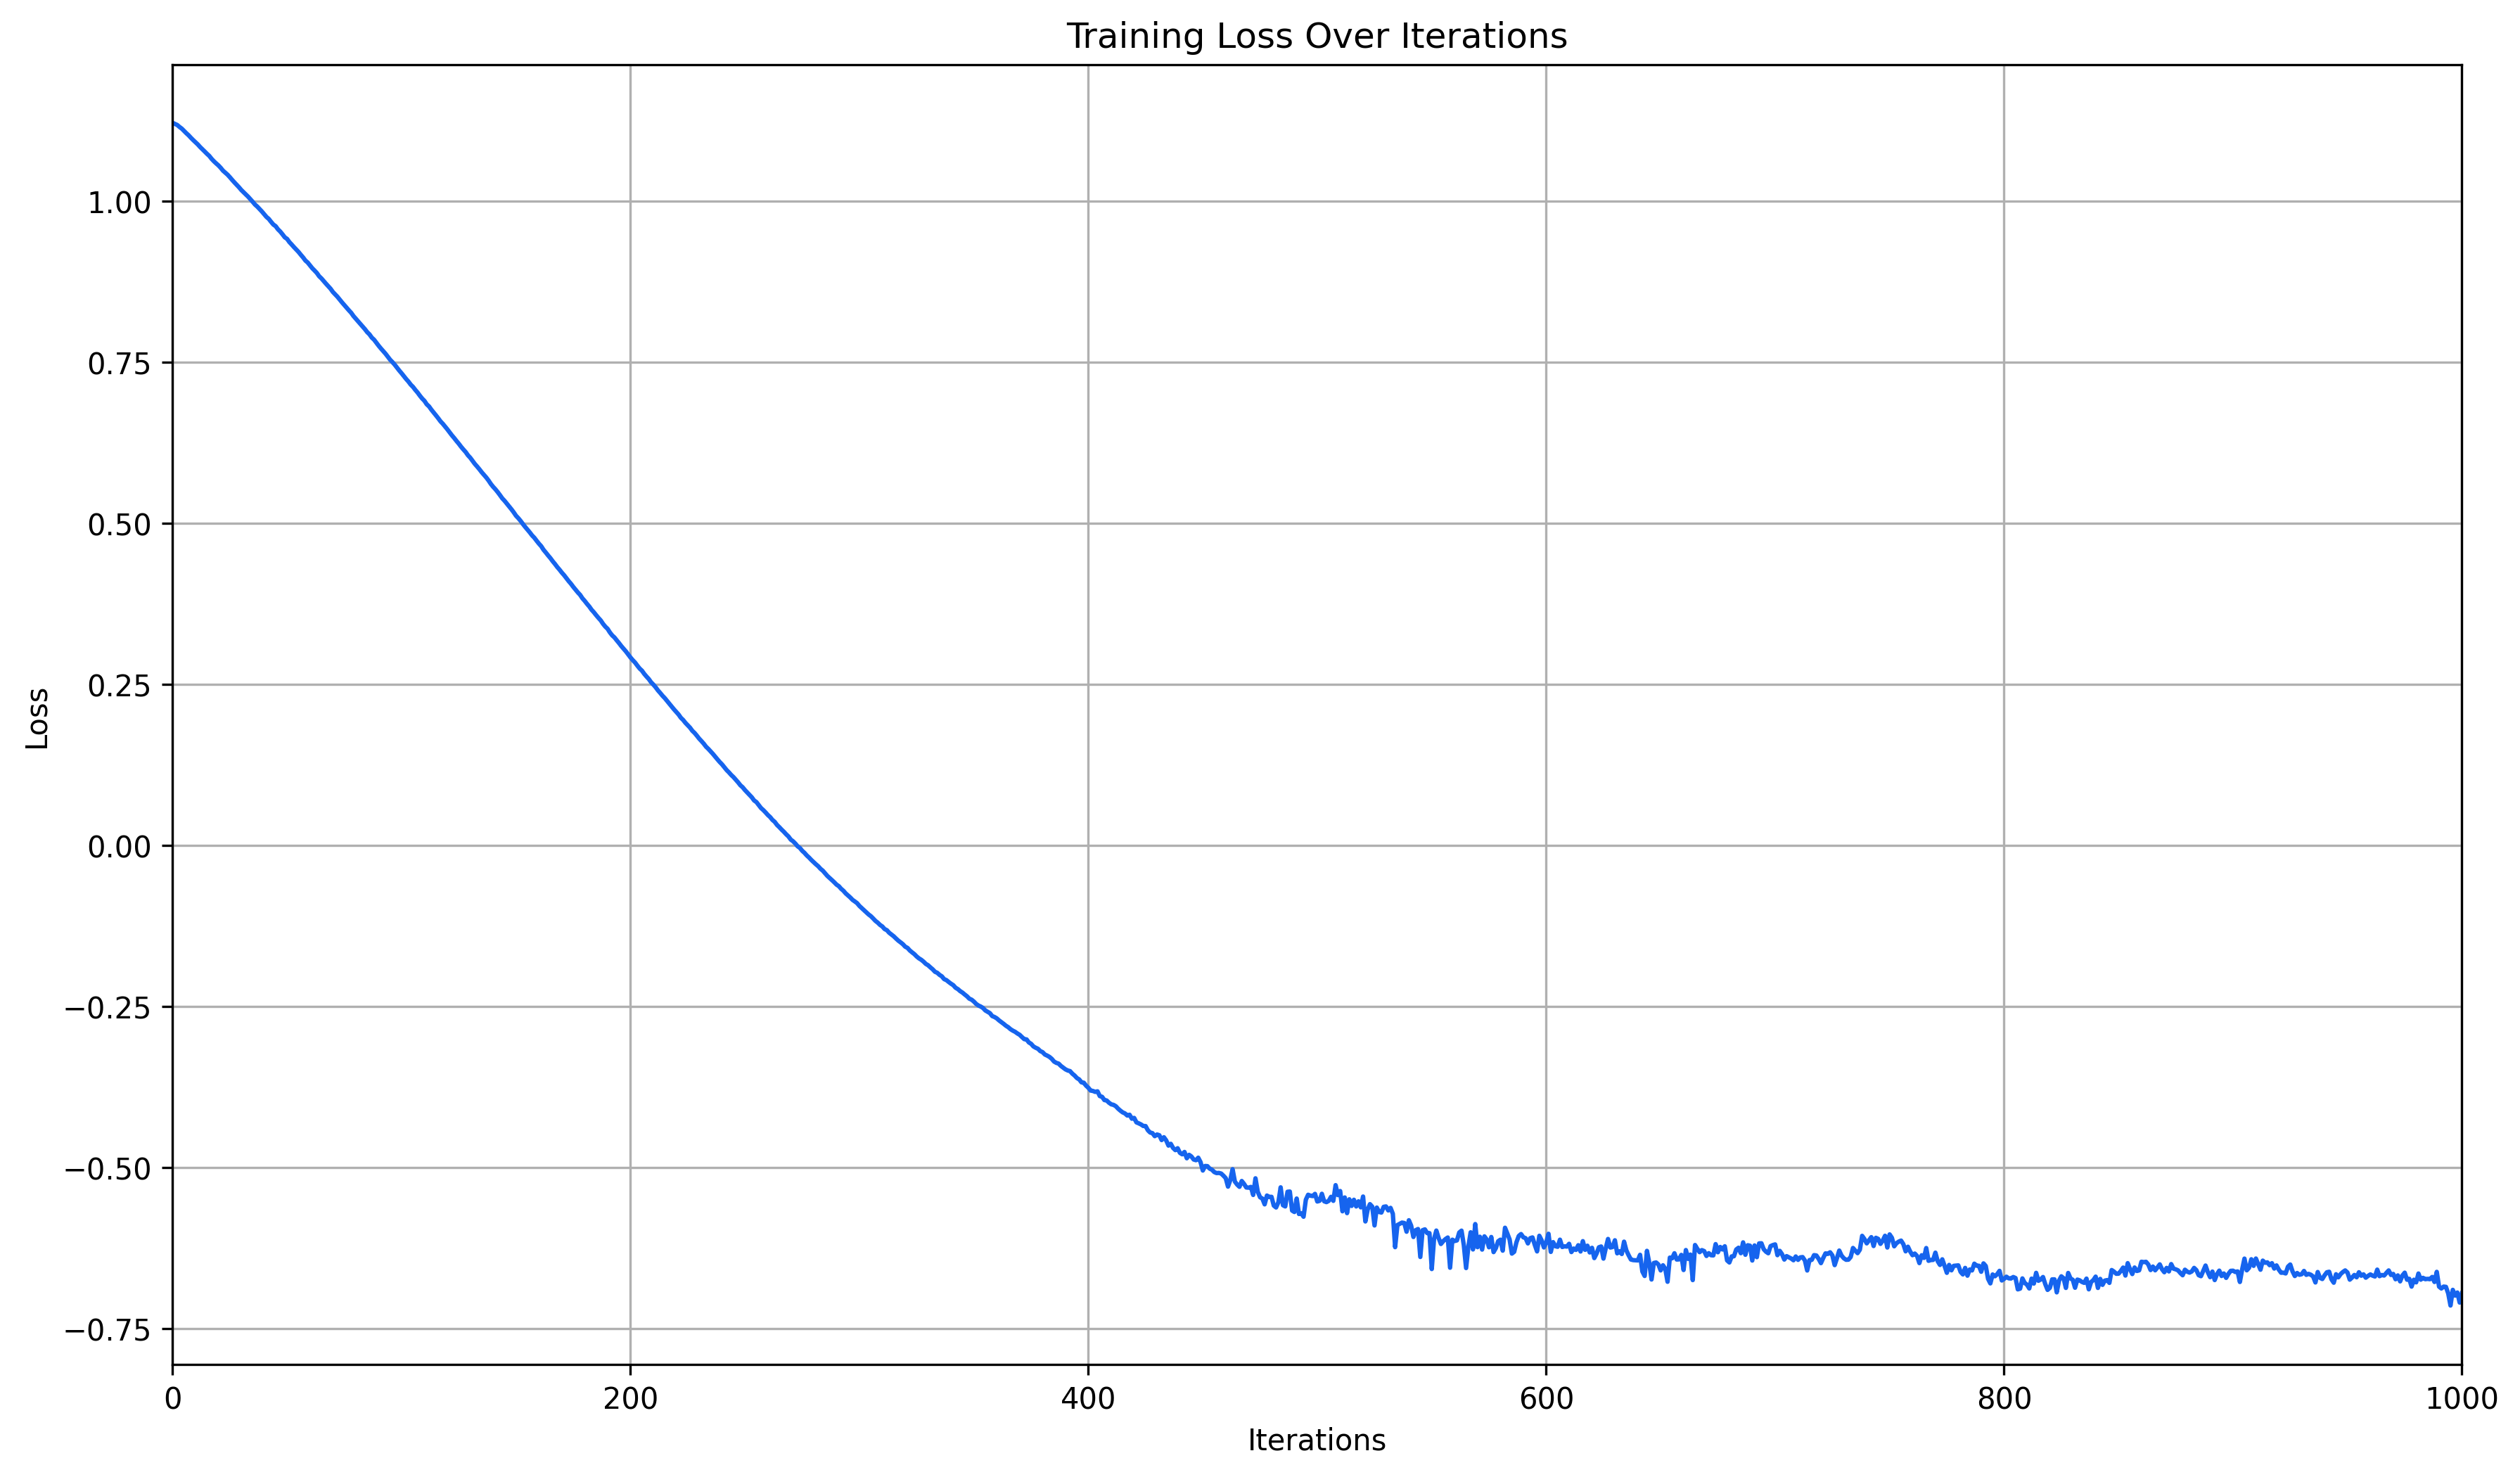

In [8]:
import numpy as np
import matplotlib.pyplot as plt

file_paths = ['/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/model/000012losses.npy']
losses = [np.load(fp) for fp in file_paths]
iterations = [np.arange(1, len(loss) + 1) for loss in losses]

plt.figure(figsize=(14, 8), dpi=300)
for i, loss in enumerate(losses):
    # Removed the 'label' argument
    plt.plot(iterations[i], loss, color='#1664EE')

plt.xlim(0, 1000)
plt.title('Training Loss Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)

# Removed plt.legend()
plt.show()


In [2]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 9.9 MB/s eta 0:00:00


In [9]:
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load and prepare data
file_path_points3d = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/sfm/points3D.txt'
depth_file_path = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/truck_depth_normalized.npy'

# Load points3D from file
def load_points3D(file_path):
    points3d_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#') or len(line.strip()) == 0:
                continue
            parts = line.split()
            point_id = int(parts[0])
            x, y, z = map(float, parts[1:4])
            r, g, b = map(int, parts[4:7])
            points3d_dict[point_id] = [x, y, z, r / 255.0, g / 255.0, b / 255.0]
    return points3d_dict

points3d_dict = load_points3D(file_path_points3d)

# Parse images file
def parse_images_file(file_path, points3d_dict):
    valid_data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if lines[i].startswith('#') or not lines[i].strip():
                i += 1
                continue

            image_data = lines[i].strip().split()
            image_name = image_data[9]
            i += 1
            keypoints_data = lines[i].strip().split()
            points2d = []
            k = 0
            while k < len(keypoints_data):
                x, y = map(float, keypoints_data[k:k+2])
                point3d_id = int(keypoints_data[k+2])
                if point3d_id != -1 and point3d_id in points3d_dict:
                    points2d.append((x, y) + tuple(points3d_dict[point3d_id]))
                k += 3
            if points2d:
                valid_data[image_name] = points2d
            i += 1

    return valid_data

file_path_images = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/sfm/images.txt'
valid_data = parse_images_file(file_path_images, points3d_dict)

def generate_test_data(valid_data, depth_file_path):
    data_by_image = {}
    depth_images = np.load(depth_file_path)
    image_indices = {name: idx for idx, name in enumerate(sorted(valid_data.keys()))}
    #movements = {'left': (-3, 0)}
    movements = {
        'left': (-3, 0),
        'right': (3, 0),
        'up': (0, -3),
        'down': (0, 3)
    }

    for image_name, data_points in valid_data.items():
        input_data = []
        output_data = []
        test_data = []

        current_depth_image = depth_images[image_indices[image_name]]
        image_height, image_width = current_depth_image.shape

        for point in data_points:
            x, y = int(point[0]), int(point[1])
            original_depth = current_depth_image[x, y] / 255.0  # Normalize depth
            input_data.append([x, y, original_depth])
            output_data.append(point[2:])

            # Generate test data around the point
            for direction, (dx, dy) in movements.items():
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < image_width and 0 <= new_y < image_height:
                    new_depth = current_depth_image[new_y, new_x] / 255.0
                    test_data.append([new_x, new_y, new_depth])

        input_data = np.array(input_data, dtype=float)
        test_data = np.array(test_data, dtype=float)
        input_data[:, 0] /= image_width  # Normalize x to [0, 1]
        input_data[:, 1] /= image_height  # Normalize y to [0, 1]
        test_data[:, 0] /= image_width
        test_data[:, 1] /= image_height
        data_by_image[image_name] = {
            'input': input_data,
            'output': np.array(output_data, dtype=float),
            'test': test_data  # Store test data
        }

    return data_by_image

data_by_image_new = generate_test_data(valid_data, depth_file_path)



test_data_normalized_new = data_by_image_new['000012.jpg']['test']
print("testdata,shape",len(test_data_normalized_new))
test_data_normalized_new = torch.tensor(test_data_normalized_new, dtype=torch.float32)



# Define the Multi-Task GP model
class MultiTaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultiTaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size([num_tasks]))
        self.covar_module = ScaleKernel(
            MaternKernel(nu=1.5, batch_shape=torch.Size([num_tasks])),
            batch_shape=torch.Size([num_tasks])
        )
        #self.covar_module = ScaleKernel(RBFKernel(batch_shape=torch.Size([num_tasks])), batch_shape=torch.Size([num_tasks]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultitaskMultivariateNormal.from_batch_mvn(MultivariateNormal(mean_x, covar_x))

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


likelihood = MultitaskGaussianLikelihood(num_tasks=6).to(device)
model = MultiTaskGPModel(train_input, train_output, likelihood, num_tasks=6).to(device)


model.load_state_dict(torch.load('/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/model/000012model.pth'))
likelihood.load_state_dict(torch.load('/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/model/000012likelihood.pth'))

# Set model to evaluation mode
model.eval()
likelihood.eval()

# Load test data
test_input = test_data_normalized_new.to(device)
test_mean_np=[]
test_va_np=[]
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_output = likelihood(model(test_input))
    test_mean = test_output.mean
    print(test_mean)
    test_mean = test_mean.cpu().numpy()
    test_mean_np.append(test_mean)
    test_variance = test_output.variance
    test_variance = test_variance.cpu().numpy()
    test_va_np.append(test_variance)
print(len(test_mean_np[0]))
np.save('/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/model/0012test_var.npy', test_va_np)
np.save('/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/truck/model/0012test_mean.npy', test_mean_np)  # Then save

'''
test_mean_np = test_mean.cpu().numpy()
test_output_np = test_output.cpu().numpy()
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(test_output_np, test_mean_np))
r2 = r2_score(test_output_np, test_mean_np)

print(f'RMSE: {rmse}')
print(f'R^2 Score: {r2}')


# Visualize predictions vs true values for one dimension (for demonstration purposes)
plt.figure(figsize=(12, 8))
plt.scatter(test_output_np[:, 0], test_mean_np[:, 0], alpha=0.6)
plt.plot([test_output_np.min(), test_output_np.max()], [test_output_np.min(), test_output_np.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values for One Dimension")
plt.show()
'''

testdata,shape 7366


<ipython-input-9-2f381b4f2d15>:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/

tensor([[0.5965, 0.4833, 0.1842, 0.4814, 0.5317, 0.4261],
        [0.6019, 0.4867, 0.1840, 0.5805, 0.6386, 0.4974],
        [0.5997, 0.4800, 0.1826, 0.5396, 0.5932, 0.4740],
        ...,
        [0.6001, 0.9897, 0.0522, 0.7628, 0.8520, 0.9710],
        [0.5965, 0.9879, 0.0550, 0.7696, 0.8603, 0.9822],
        [0.6016, 0.9911, 0.0503, 0.7589, 0.8484, 0.9649]], device='cuda:0')
7366


'\ntest_mean_np = test_mean.cpu().numpy()\ntest_output_np = test_output.cpu().numpy()  \nfrom sklearn.metrics import mean_squared_error, r2_score\n\nrmse = np.sqrt(mean_squared_error(test_output_np, test_mean_np))\nr2 = r2_score(test_output_np, test_mean_np)\n\nprint(f\'RMSE: {rmse}\')\nprint(f\'R^2 Score: {r2}\')\n\n\n# Visualize predictions vs true values for one dimension (for demonstration purposes)\nplt.figure(figsize=(12, 8))\nplt.scatter(test_output_np[:, 0], test_mean_np[:, 0], alpha=0.6)\nplt.plot([test_output_np.min(), test_output_np.max()], [test_output_np.min(), test_output_np.max()], \'r--\')\nplt.xlabel("True Values")\nplt.ylabel("Predictions")\nplt.title("True vs Predicted Values for One Dimension")\nplt.show()\n'

#In this section, we will evaluate how different length-scale in kernel function affect regression results.

##Make sure the four most contributing images

Top 4 images based on input data size: ['000094.png', '000016.png', '000093.png', '000096.png']
Processing 000094.png...


<ipython-input-15-2ffc8f63577c>:152: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_cycle = plt.cm.get_cmap('tab10')


[1.385918378829956, 1.3681020736694336, 1.338252067565918, 1.3107284307479858, 1.2869623899459839, 1.265528678894043, 1.2444627285003662, 1.222990870475769, 1.2029802799224854, 1.1856789588928223, 1.164278507232666, 1.147230625152588, 1.1281147003173828, 1.1102430820465088, 1.0934523344039917, 1.0756325721740723, 1.0601176023483276, 1.0437357425689697, 1.0297374725341797, 1.0119531154632568, 0.9963300228118896, 0.9852521419525146, 0.9665365815162659, 0.9582180380821228, 0.9418073892593384, 0.931580126285553, 0.9179341197013855, 0.9002222418785095, 0.8885633945465088, 0.8755841851234436, 0.8604316115379333, 0.8505117297172546, 0.8355847001075745, 0.8202046751976013, 0.8141535520553589, 0.793002188205719, 0.7810207605361938, 0.7691386938095093, 0.7508630752563477, 0.7488225698471069, 0.7300270795822144, 0.7159112691879272, 0.7012322545051575, 0.6903278827667236, 0.675750732421875, 0.6652361154556274, 0.6486275792121887, 0.6381549835205078, 0.6165569424629211, 0.6076717376708984, 0.598112

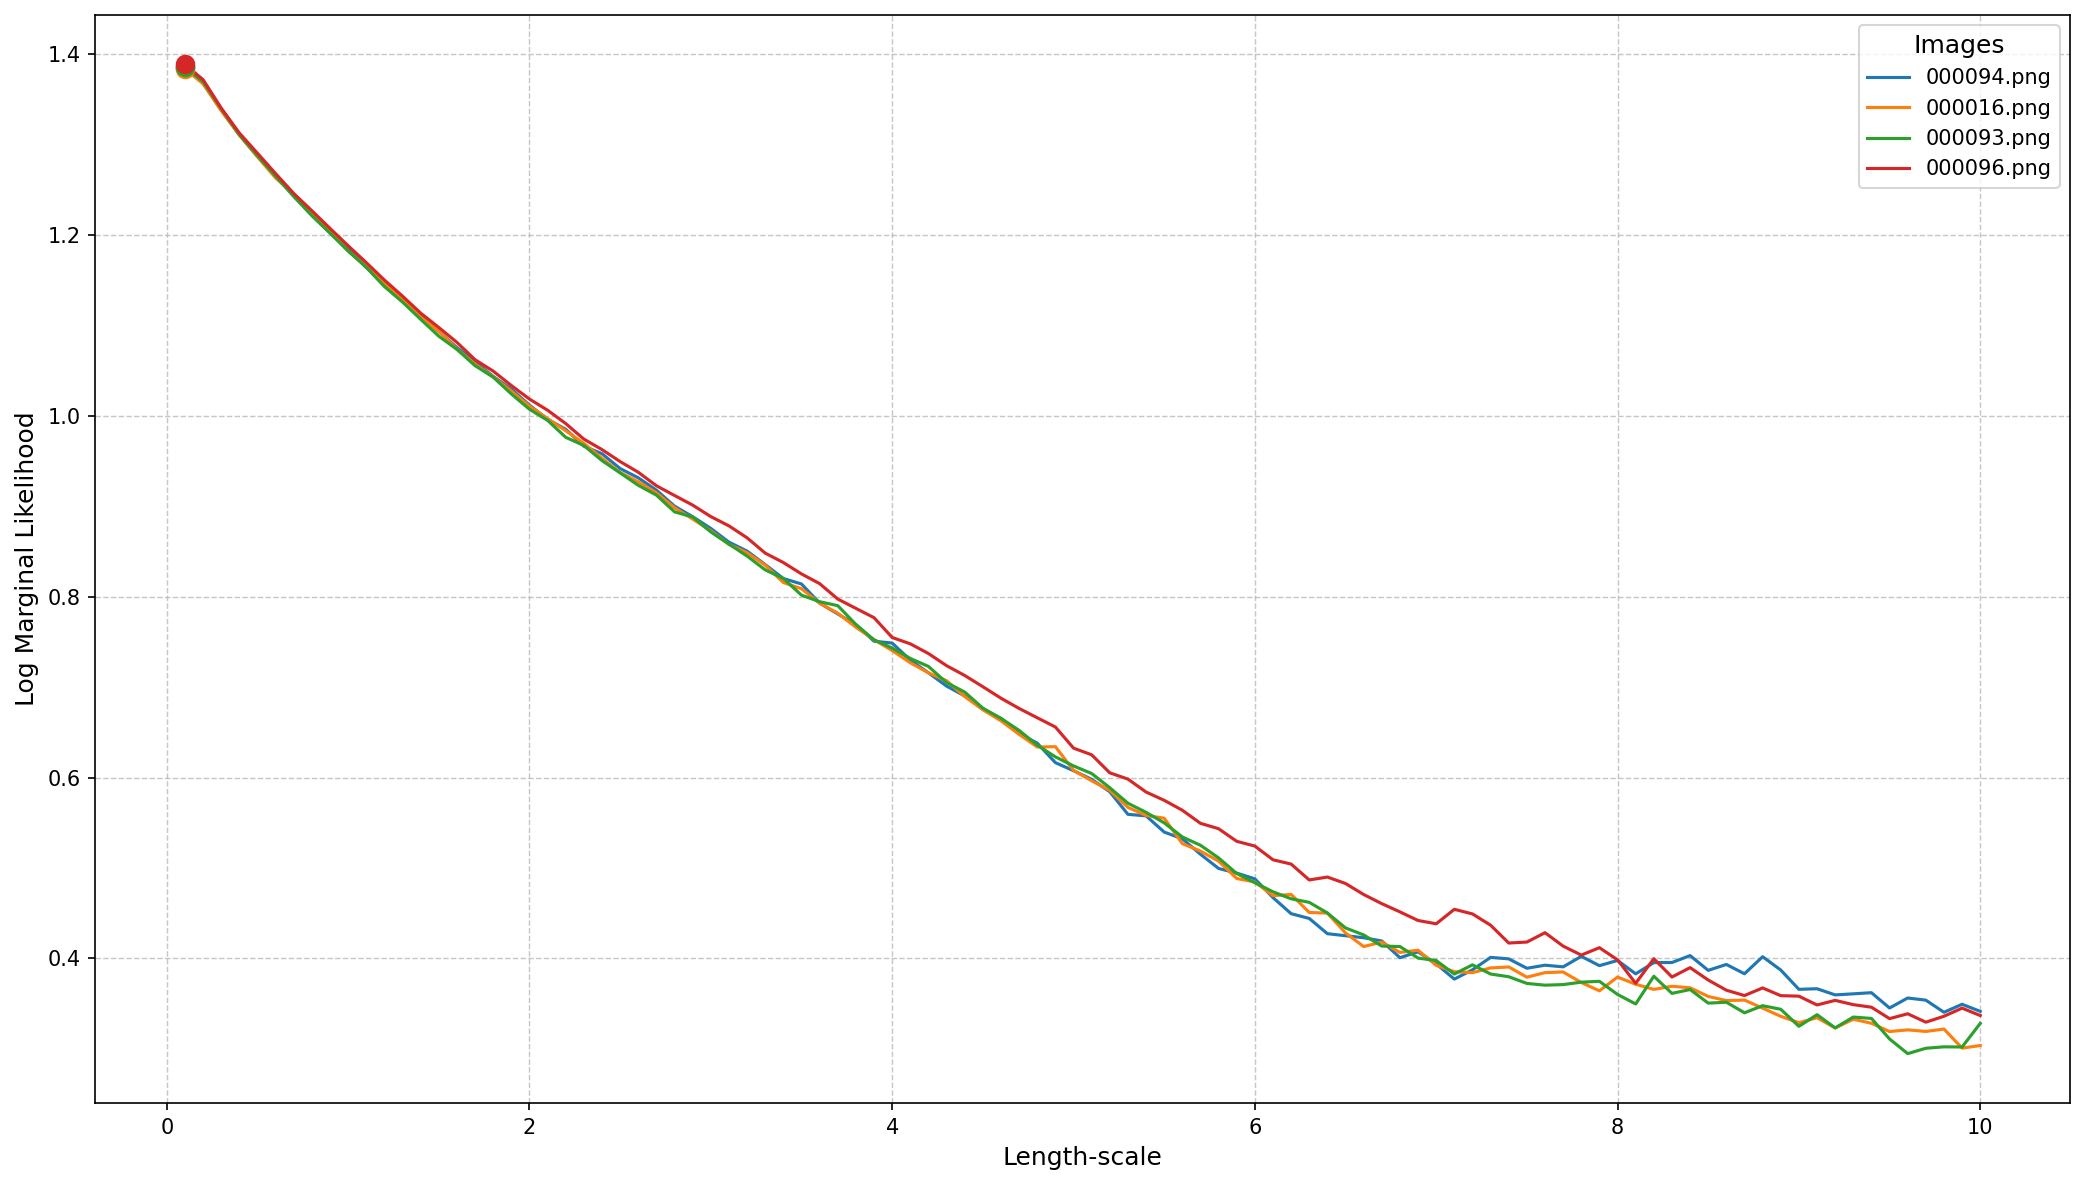

In [15]:
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline

# Load and prepare data
file_path_points3d = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/lego/lego_sfm_output/points3D.txt'
depth_file_path = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/lego/lego_depth_normalized.npy'

# Load points3D from file
def load_points3D(file_path):
    points3d_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#') or len(line.strip()) == 0:
                continue
            parts = line.split()
            point_id = int(parts[0])
            x, y, z = map(float, parts[1:4])
            r, g, b = map(int, parts[4:7])
            points3d_dict[point_id] = [x, y, z, r / 255.0, g / 255.0, b / 255.0]
    return points3d_dict

points3d_dict = load_points3D(file_path_points3d)

# Parse images file
def parse_images_file(file_path, points3d_dict):
    valid_data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if lines[i].startswith('#') or not lines[i].strip():
                i += 1
                continue

            image_data = lines[i].strip().split()
            image_name = image_data[9]
            i += 1
            keypoints_data = lines[i].strip().split()
            points2d = []
            k = 0
            while k < len(keypoints_data):
                x, y = map(float, keypoints_data[k:k+2])
                point3d_id = int(keypoints_data[k+2])
                if point3d_id != -1 and point3d_id in points3d_dict:
                    points2d.append((x, y) + tuple(points3d_dict[point3d_id]))
                k += 3
            if points2d:
                valid_data[image_name] = points2d
            i += 1

    return valid_data

file_path_images = '/content/drive/MyDrive/3dgs/3dgscream/Scaffold-GS/gp_vis/gp_vis/lego/lego_sfm_output/images.txt'
valid_data = parse_images_file(file_path_images, points3d_dict)

def generate_test_data(valid_data, depth_file_path):
    data_by_image = {}
    depth_images = np.load(depth_file_path)
    image_indices = {name: idx for idx, name in enumerate(sorted(valid_data.keys()))}
    movements = {'left': (-5, 0)}

    for image_name, data_points in valid_data.items():
        input_data = []
        output_data = []
        test_data = []

        current_depth_image = depth_images[image_indices[image_name]]
        image_height, image_width = current_depth_image.shape

        for point in data_points:
            x, y = int(point[0]), int(point[1])
            original_depth = current_depth_image[y, x] / 255.0  # Normalize depth
            input_data.append([x, y, original_depth])
            output_data.append(point[2:])

            # Generate test data around the point
            for direction, (dx, dy) in movements.items():
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < image_width and 0 <= new_y < image_height:
                    new_depth = current_depth_image[new_y, new_x] / 255.0
                    test_data.append([new_x, new_y, new_depth])

        input_data = np.array(input_data, dtype=float)
        test_data = np.array(test_data, dtype=float)
        input_data[:, 0] /= image_width  # Normalize x to [0, 1]
        input_data[:, 1] /= image_height  # Normalize y to [0, 1]
        test_data[:, 0] /= image_width
        test_data[:, 1] /= image_height
        data_by_image[image_name] = {
            'input': input_data,
            'output': np.array(output_data, dtype=float),
            'test': test_data  # Store test data
        }

    return data_by_image

data_by_image_new = generate_test_data(valid_data, depth_file_path)

from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler

scaler_output = MinMaxScaler()
input_data_normalized = data_by_image_new['000016.png']['input']
output_data_normalized = scaler_output.fit_transform(data_by_image_new['000016.png']['output'])

# Split data into train and test sets
train_input, test_input, train_output, test_output = train_test_split(input_data_normalized, output_data_normalized, test_size=0.05, random_state=42)

train_input = torch.tensor(train_input, dtype=torch.float32)
train_output = torch.tensor(train_output, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)
test_output = torch.tensor(test_output, dtype=torch.float32)
#noise_factor = 0.05  # Adjust the noise level as per requirement
#noisy_input_data = train_input + noise_factor * torch.randn_like(train_input)
#train_input=noisy_input_data
# Define the Multi-Task GP model
class MultiTaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultiTaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size([num_tasks]))
        '''
        self.covar_module = ScaleKernel(
            MaternKernel(nu=0.5, batch_shape=torch.Size([num_tasks])),
            batch_shape=torch.Size([num_tasks])
        )
        '''

        self.covar_module = ScaleKernel(RBFKernel(batch_shape=torch.Size([num_tasks])), batch_shape=torch.Size([num_tasks]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultitaskMultivariateNormal.from_batch_mvn(MultivariateNormal(mean_x, covar_x))

top_images = sorted(data_by_image.items(), key=lambda x: len(x[1]['input']), reverse=True)[:4]
top_image_names = [image[0] for image in top_images]
length_scales = np.linspace(0.1, 10, 100)

print("Top 4 images based on input data size:", top_image_names)

top_images = top_image_names

# Set up the figure for combined plotting
plt.figure(figsize=(14, 8), dpi=150)
color_cycle = plt.cm.get_cmap('tab10')

average_length_scales = []
log_marginal_likelihoods_1 = []
# Loop through the selected images and calculate log marginal likelihood
for idx, image_name in enumerate(top_images):
    log_marginal_likelihoods = []

    print(f"Processing {image_name}...")
    data = data_by_image[image_name]

    # Normalize the data
    input_data_normalized = data['input']
    output_data_normalized = scaler_output.fit_transform(data['output'])

    # Convert to tensors
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_data = torch.tensor(input_data_normalized, dtype=torch.float32).to(device)
    output_data = torch.tensor(output_data_normalized, dtype=torch.float32).to(device)

    # Set up model and likelihood
    likelihood = MultitaskGaussianLikelihood(num_tasks=6).to(device)
    model = MultiOutputGP(input_data, output_data, likelihood).to(device)

    # Train the model for different length-scales
    for length_scale in length_scales:
        model.covar_module.lengthscale = length_scale
        model.train()
        likelihood.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        optimizer.zero_grad()
        output = model(input_data)
        loss = -mll(output, output_data)
        loss.backward()
        optimizer.step()

        log_marginal_likelihoods.append(loss.item())
    print(log_marginal_likelihoods)
    log_marginal_likelihoods_1.append(log_marginal_likelihoods)
    # Find the best length-scale for this image and store it
    best_index = np.argmax(log_marginal_likelihoods)
    best_length_scale = length_scales[best_index]
    average_length_scales.append(best_length_scale)

    # Plot the log marginal likelihood for this image
    plt.plot(length_scales, log_marginal_likelihoods, label=f'{image_name}', color=color_cycle(idx))
    plt.scatter([best_length_scale], [log_marginal_likelihoods[best_index]], color=color_cycle(idx), s=70, zorder=5)
np.save('average_length_scales.npy',average_length_scales)
np.save('log_marginal_likelihoods_1.npy',log_marginal_likelihoods_1)
# Compute the average best length-scale
average_best_length_scale = np.mean(average_length_scales)
print(f"The average best length-scale is: {average_best_length_scale:.2f}")

# Customize and show the combined plot
#plt.title('Effect of Length-Scale on GP Model for Top Images', fontsize=18, fontweight='bold')
plt.xlabel('Length-scale', fontsize=12)
plt.ylabel('Log Marginal Likelihood', fontsize=12)
plt.legend(title="Images", fontsize=10, title_fontsize=12, loc='best')
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()






